In [4]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(2048)
environ['n_epochs']= '1000'
environ['batch_norm']= 'True'
environ['loss_func']='MAPE'
environ['layers'] = '600 350 200 180'
environ['dropouts'] = '0.1 '* 4
environ['log'] = 'False'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:4'
environ['dataset'] = 'data/speedup_dataset2.pkl'

%run utils.ipynb

In [5]:
train_dl, val_dl, test_dl = train_dev_split(dataset, batch_size, num_workers, log=log)

db = fai.basic_data.DataBunch(train_dl, val_dl, test_dl, device=device)

In [6]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]


model = None 

if batch_norm:
    model = Model_BN(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
else:
    model = Model(input_size, output_size)
    
if loss_func == 'MSE':
    criterion = nn.MSELoss()
elif loss_func == 'MAPE':
    criterion = mape_criterion
elif loss_func == 'SMAPE':
    criterion = smape_criterion

l = fai.Learner(db, model, loss_func=criterion, metrics=[mape_criterion, rmse_criterion])

if optimizer == 'SGD':
    l.opt_func = optim.SGD

In [4]:
l = l.load(f"r_speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [125]:
l.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


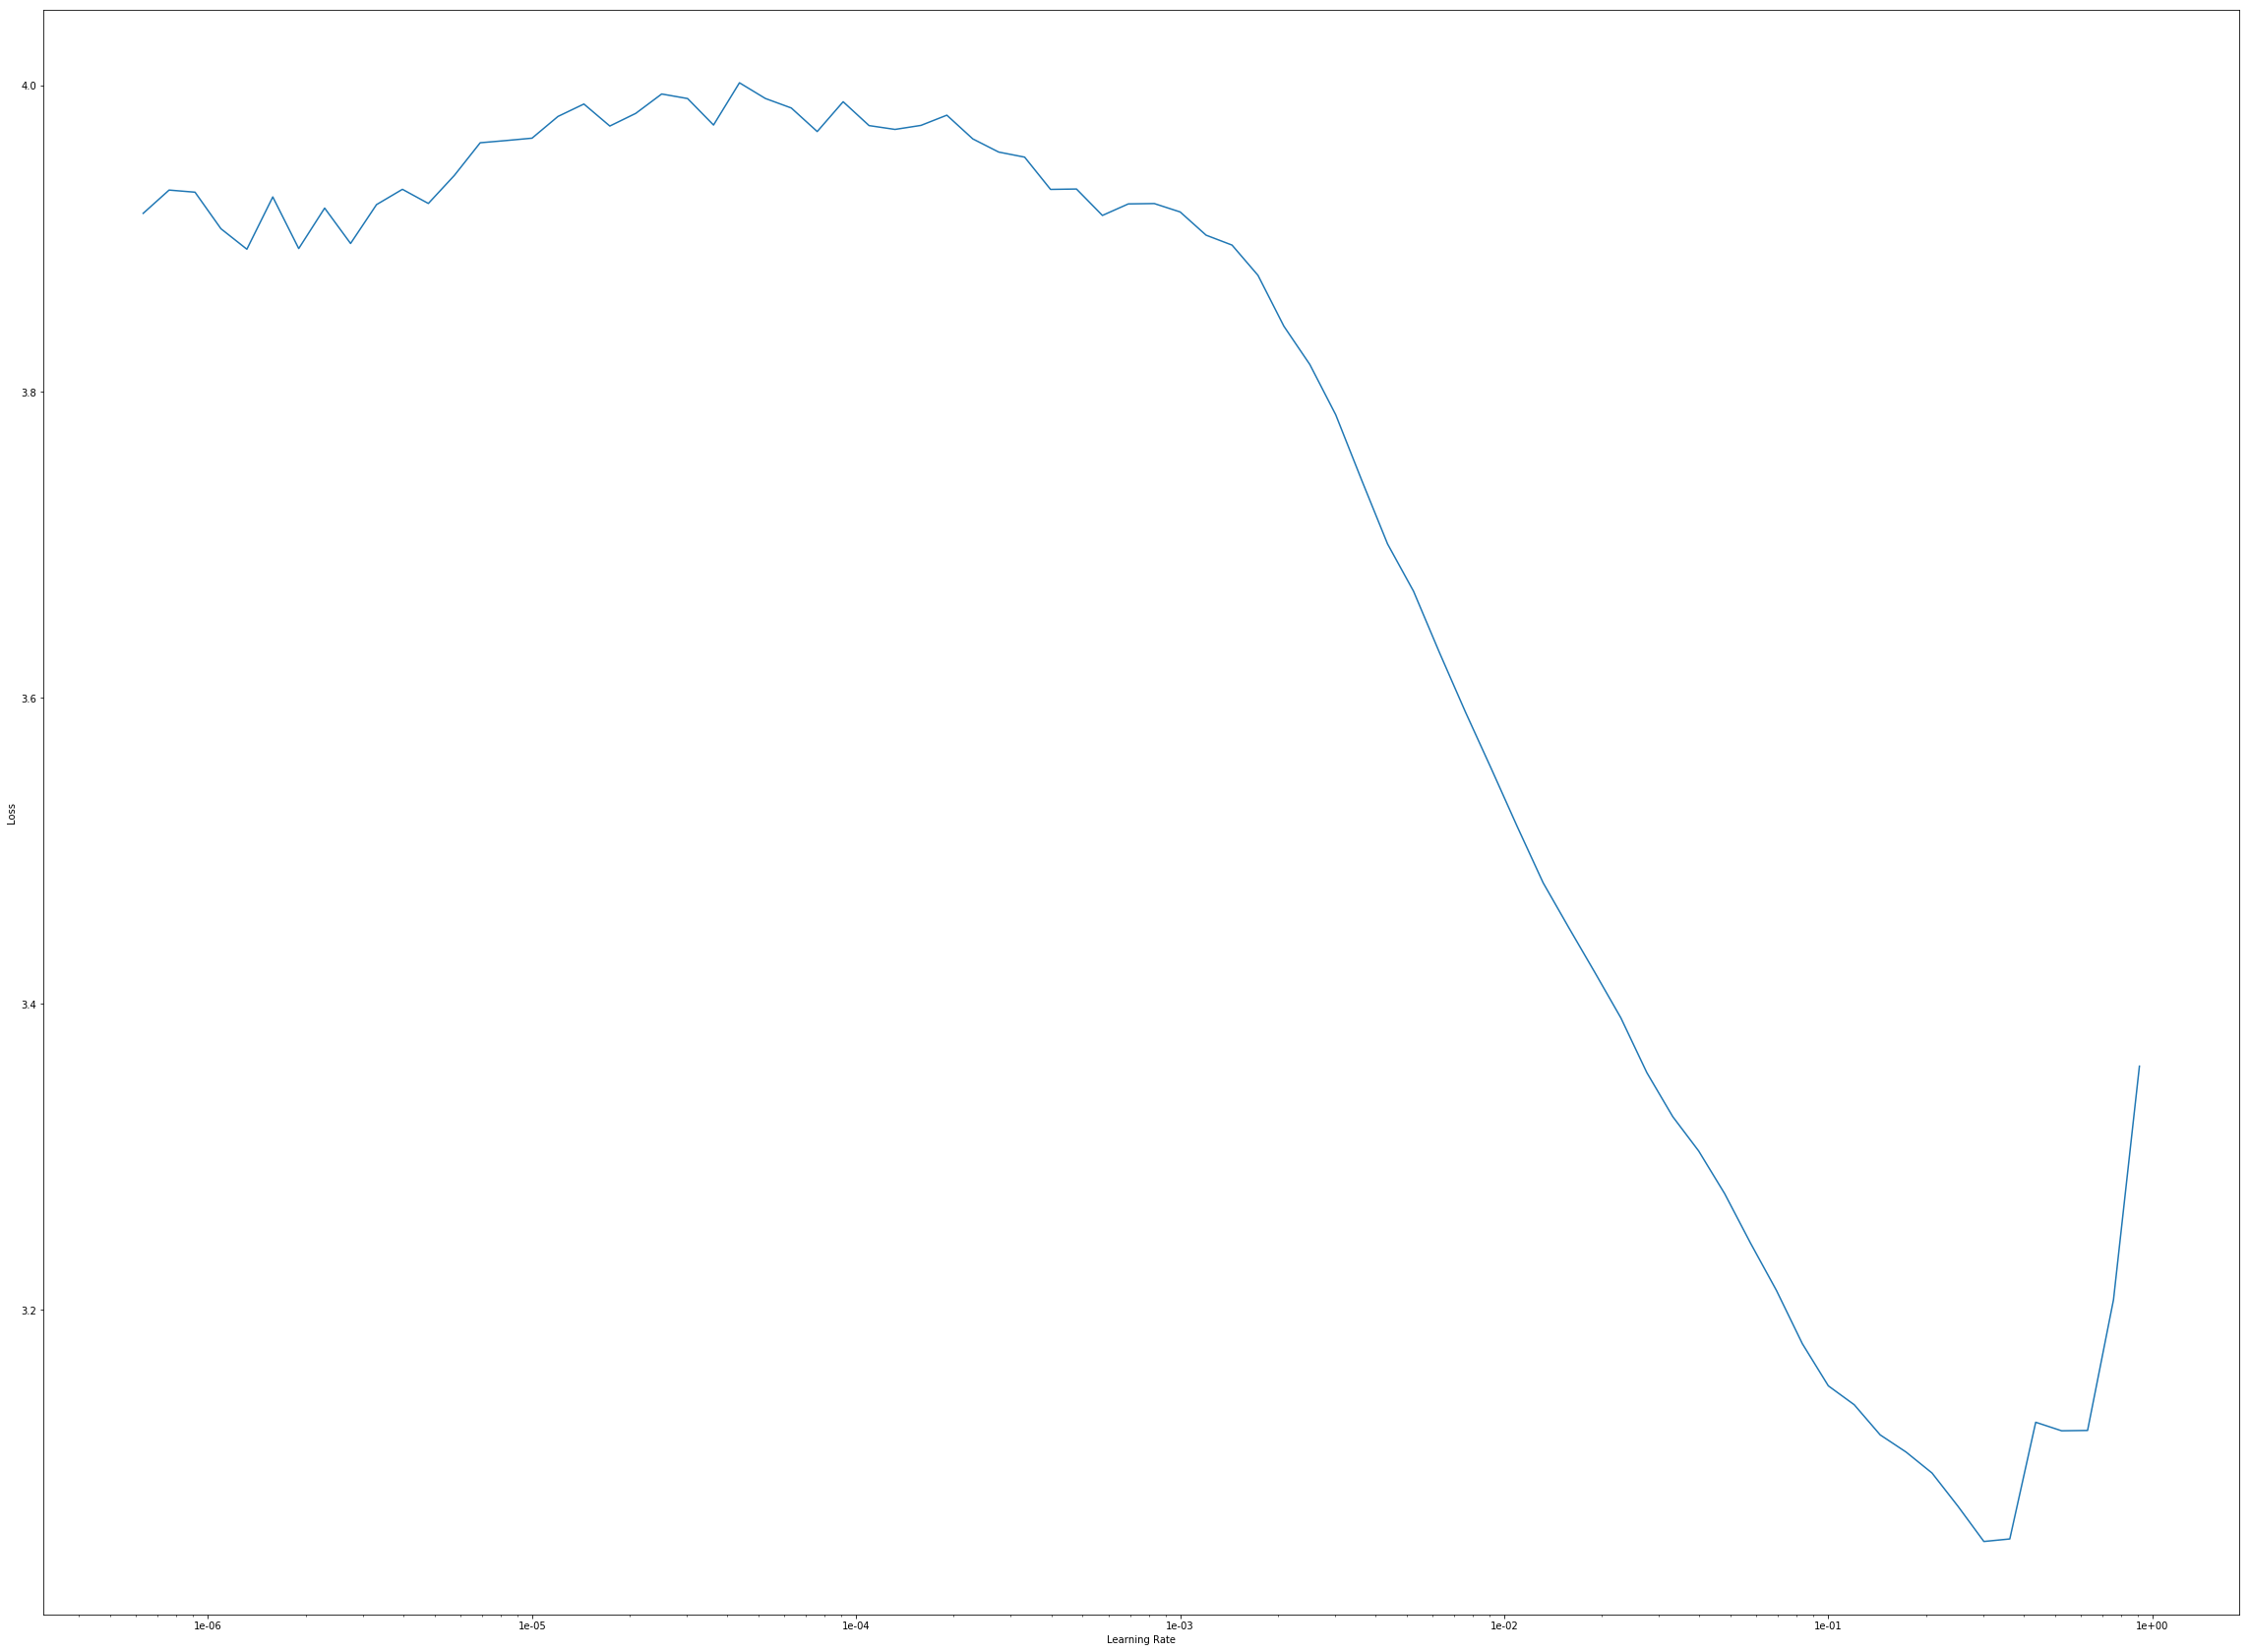

In [126]:
l.recorder.plot()

In [7]:
lr = 1e-03

In [8]:
l.fit_one_cycle(600, lr)

epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,102.462837,89.915024,89.915024,2.250221
2,95.942848,89.159119,89.159119,2.241213
3,93.677299,88.585869,88.585869,2.241689
4,92.049332,88.617554,88.617554,2.237574
5,90.969185,88.596176,88.596176,2.234123
6,91.528877,88.353172,88.353172,2.234489
7,89.688362,87.845184,87.845184,2.229401
8,88.902145,86.188789,86.188789,2.225424
9,87.189957,84.940178,84.940178,2.218786
10,86.617989,84.251053,84.251053,2.217868


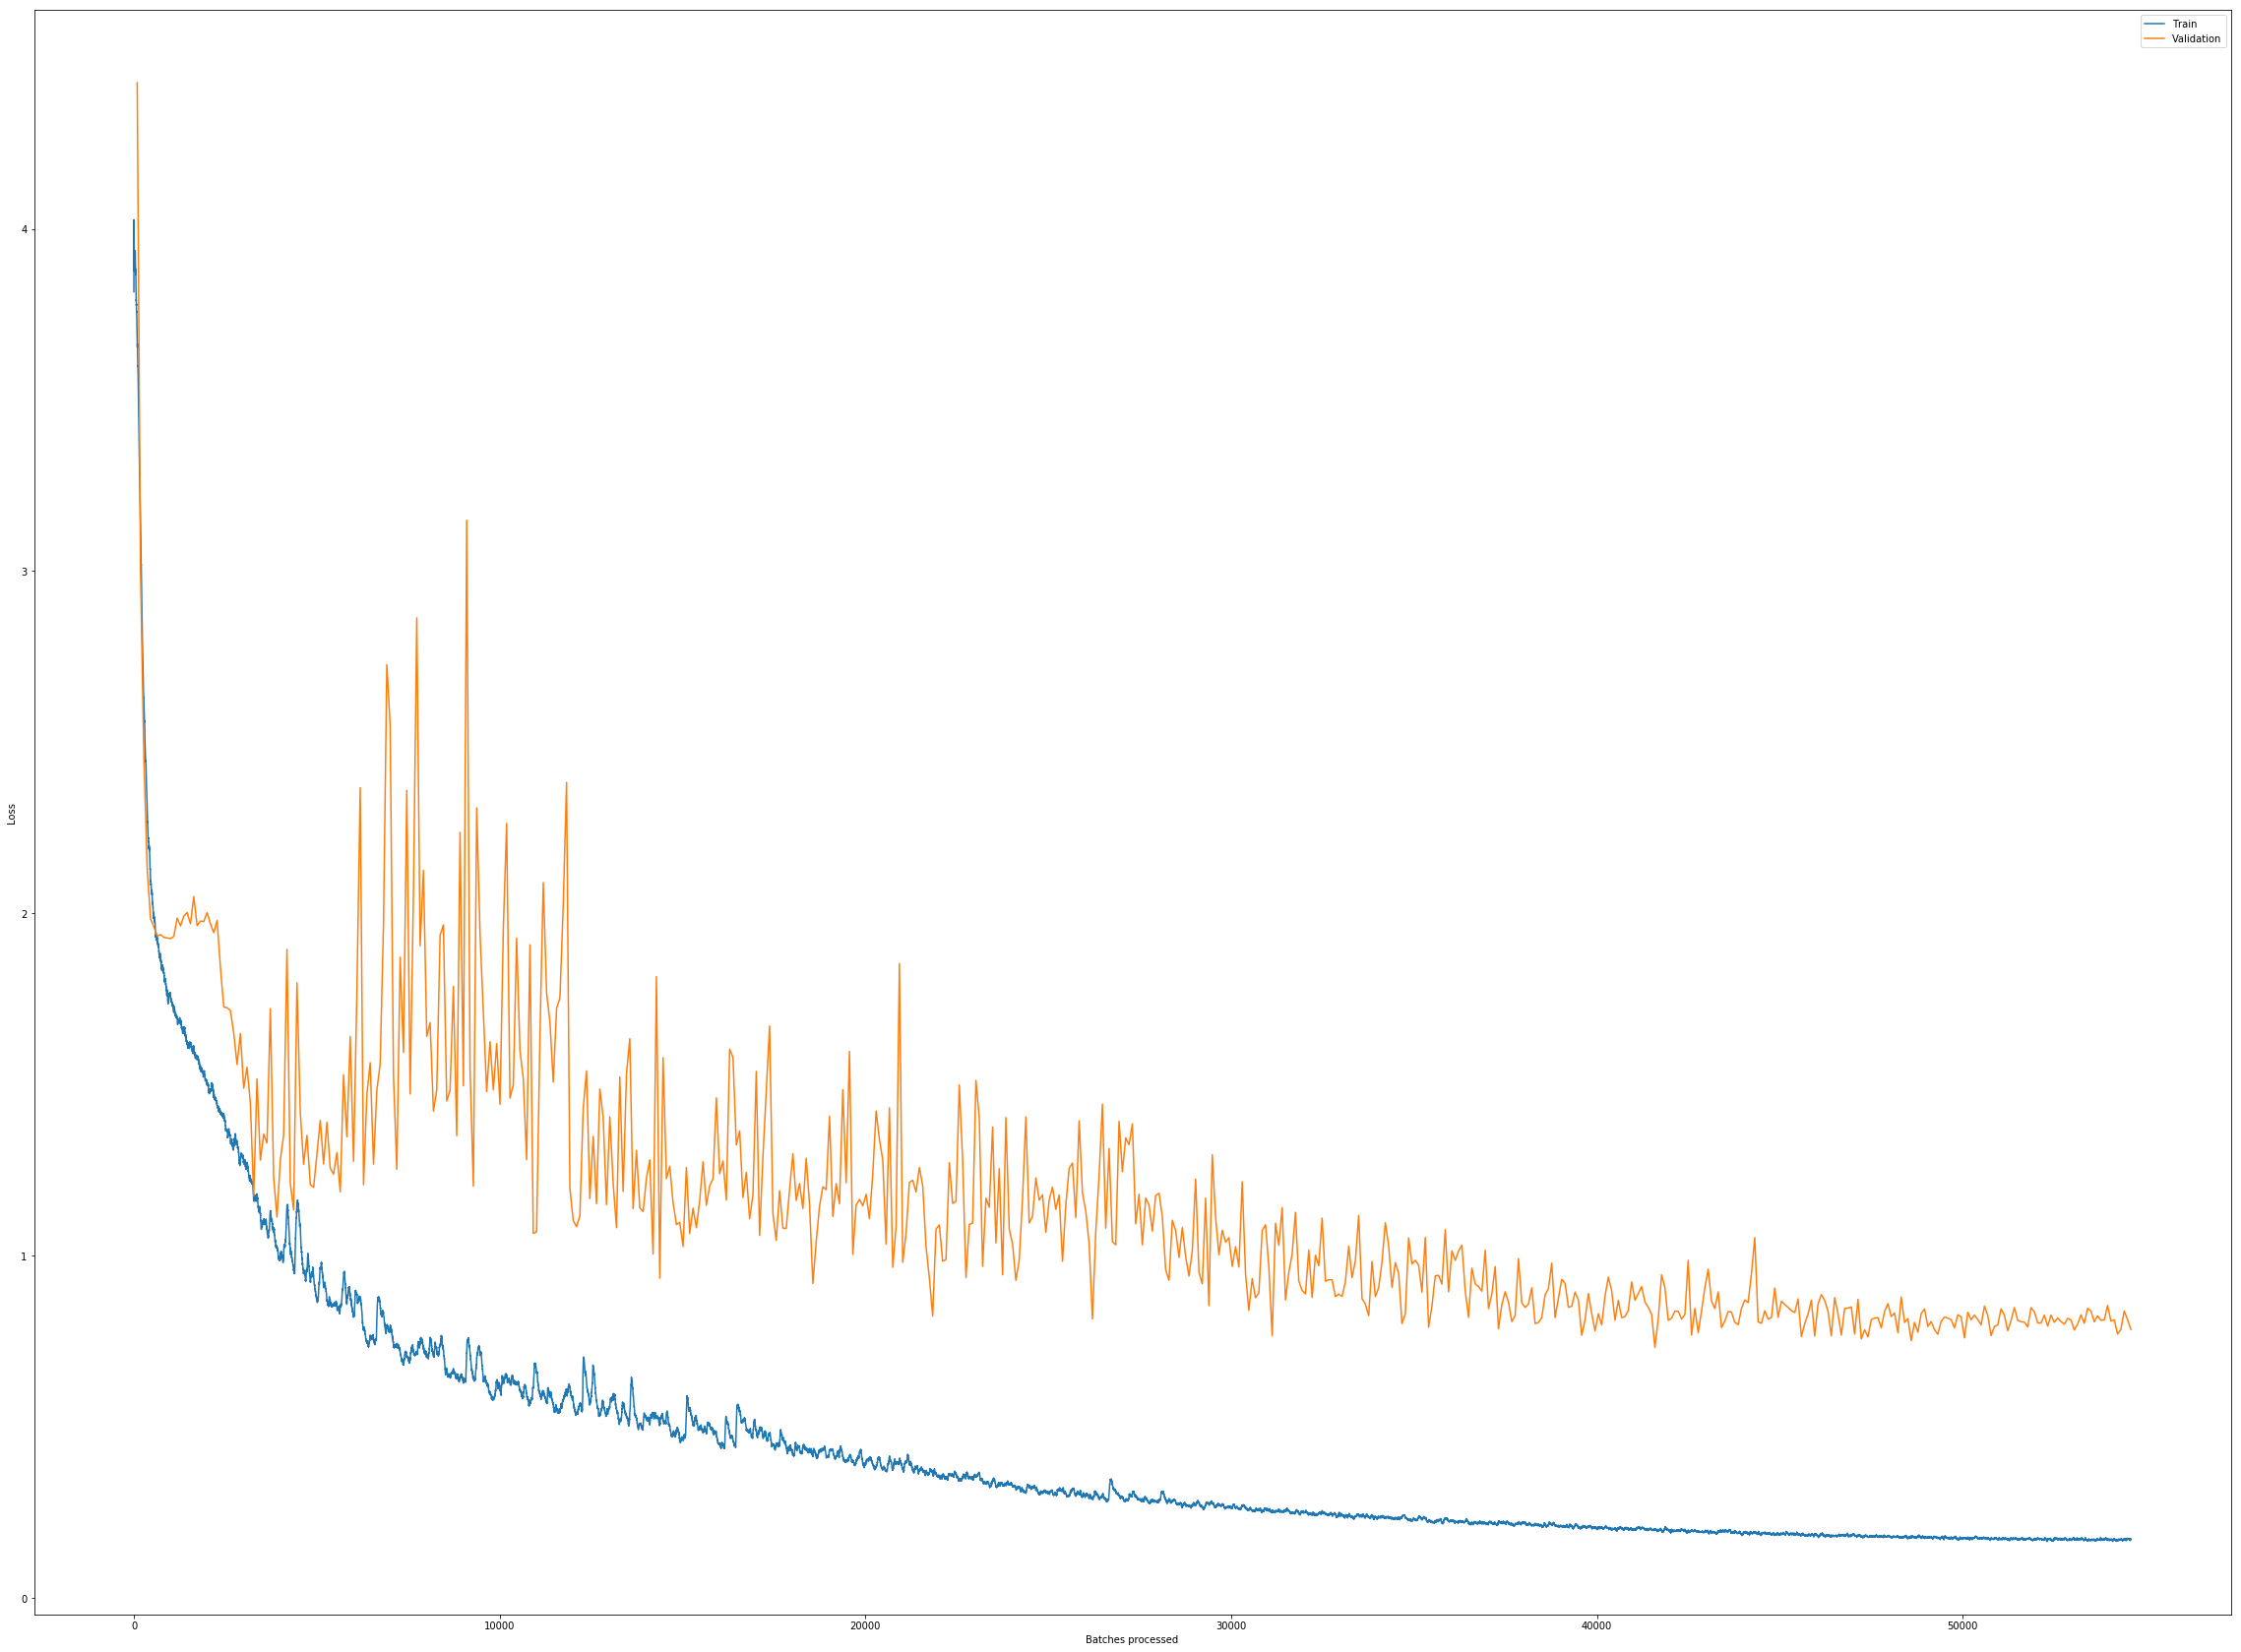

In [129]:
l.recorder.plot_losses()

In [6]:
l.save(f"r_speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [7]:
!ls models

old_models
old_repr
r_speedup_Adam_batch_norm_True_MAPE_nlayers_5_log_False.pth
speedup_Adam_batch_norm_True_MAPE_nlayers_5_log_False2.pth
speedup_Adam_batch_norm_True_MAPE_nlayers_5_log_False.pth
speedup_Adam_batch_norm_True_MSE_nlayers_5_log_False.pth
speedup_Adam_batch_norm_True_MSE_nlayers_5_log_True.pth
tmp.pth


In [111]:
val_df = get_results_df(val_dl, l.model)
train_df = get_results_df(train_dl, l.model)

In [116]:
df = train_df


In [117]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,185651.000000,185651.000000,1.856510e+05,185651.000000
mean,1.159134,1.184810,1.515271e-01,16.350126
std,1.564008,1.613917,4.039645e-01,49.778847
min,0.010645,0.008491,2.384186e-07,0.000060
25%,0.216299,0.211613,1.029227e-02,3.166194
50%,0.569257,0.565550,3.776443e-02,7.030761
75%,1.389433,1.394052,1.252649e-01,13.793568
max,11.054943,16.089287,1.534635e+01,3100.805420


In [118]:
df = val_df

In [119]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.717750,1.601825,0.545405,50.500225
std,1.808425,1.653595,0.805434,75.607666
min,0.012248,0.010685,0.000005,0.001589
25%,0.372329,0.301894,0.054618,8.127786
50%,1.037479,0.970127,0.214614,23.571514
75%,2.149681,2.176448,0.696176,61.788719
max,8.437875,7.522550,5.974429,654.431885


In [120]:
df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,25.000000,25.0,25.000000,25.000000
mean,2.385324,1.0,1.438993,143.899323
std,1.898048,0.0,1.855988,185.598831
min,0.731159,1.0,0.021526,2.152550
25%,0.973027,1.0,0.069987,6.998700
50%,1.585838,1.0,0.585838,58.583771
75%,3.934247,1.0,2.934247,293.424683
max,6.791101,1.0,5.791101,579.110046


In [48]:
df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,10908.000000,10908.000000,10908.000000,10908.000000
mean,1.300379,1.544865,0.348264,17.498978
std,1.134063,1.561985,0.874742,19.460262
min,0.040741,0.080195,0.000011,0.000417
25%,0.521132,0.561271,0.037481,4.959255
50%,0.952309,1.011548,0.103626,11.225842
75%,1.701679,1.967590,0.268848,22.333059
max,7.149683,16.089287,15.834622,476.782654


In [49]:
df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,5388.000000,5388.000000,5388.000000,5388.000000
mean,4.646883,5.080168,0.709873,17.410728
std,2.274305,2.592474,0.847952,34.551174
min,0.041153,0.058317,0.000006,0.000110
25%,2.416280,2.779300,0.175089,4.599086
50%,5.243072,5.502153,0.416792,10.081613
75%,6.300526,6.526127,0.916621,17.963830
max,8.230931,13.560771,6.250570,510.743958


In [50]:
df[(df.interchange==1) & (df.unroll == 0) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,1758.000000,1758.000000,1758.000000,1758.000000
mean,1.041926,1.452486,0.451720,23.524038
std,1.040951,1.578704,0.813260,25.382376
min,0.041223,0.018637,0.000014,0.005628
25%,0.306825,0.347235,0.030223,6.690400
50%,0.681719,0.822524,0.115805,15.353576
75%,1.462868,2.103264,0.442162,31.986423
max,6.201118,9.472253,5.777220,405.513367


In [51]:
df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,21395.000000,21395.000000,21395.000000,21395.000000
mean,1.103823,1.345353,0.325749,19.157253
std,1.122763,1.548089,0.875139,22.390285
min,0.037974,0.029894,0.000007,0.000545
25%,0.387534,0.399394,0.031919,5.276947
50%,0.853066,0.889977,0.086671,11.755613
75%,1.368872,1.568050,0.212368,23.404687
max,8.301966,13.433655,12.628229,364.638855


In [52]:
df[(df.interchange==1) & (df.unroll == 1) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,26827.000000,26827.000000,26827.000000,26827.000000
mean,2.278949,2.478805,0.312914,13.936263
std,1.690642,1.895653,0.552439,35.758522
min,0.041220,0.018075,0.000003,0.000124
25%,0.873289,0.883696,0.049614,3.965816
50%,1.820674,1.956570,0.140420,8.129169
75%,3.415022,3.795769,0.346526,14.133539
max,7.781519,13.558847,6.984952,659.840881


In [53]:
df[(df.interchange==1) & (df.unroll == 0) & (df.tile == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,38476.000000,38476.000000,38476.000000,38476.000000
mean,0.599790,0.718080,0.161907,16.824739
std,0.726942,0.959410,0.441344,19.137383
min,0.011075,0.008774,0.000001,0.002214
25%,0.159066,0.163858,0.010282,4.783708
50%,0.350566,0.374172,0.037043,10.798526
75%,0.797795,0.897981,0.118515,21.021241
max,6.714707,9.643795,7.808821,224.782593


In [54]:
df[(df.interchange==1) & (df.unroll == 1) & (df.tile == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,80352.000000,80352.000000,8.035200e+04,80352.000000
mean,0.502504,0.618813,1.499550e-01,16.857380
std,0.697265,0.935955,4.647943e-01,20.027716
min,0.011103,0.008491,2.942979e-07,0.000142
25%,0.118478,0.126692,8.149397e-03,4.663052
50%,0.289729,0.305125,2.876675e-02,10.372399
75%,0.639897,0.745241,9.044305e-02,20.579370
max,7.473004,12.004527,8.477986e+00,453.119904


In [56]:
df[(df.interchange + df.tile + df.unroll != 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,185104.000000,185104.000000,1.851040e+05,185104.000000
mean,1.022474,1.185355,2.272181e-01,16.810253
std,1.374168,1.616282,5.942063e-01,23.641901
min,0.011075,0.008491,2.942979e-07,0.000110
25%,0.197577,0.210773,1.411321e-02,4.647739
50%,0.502107,0.562228,5.195722e-02,10.257700
75%,1.149322,1.398968,1.731274e-01,19.895230
max,8.301966,16.089287,1.583462e+01,659.840881


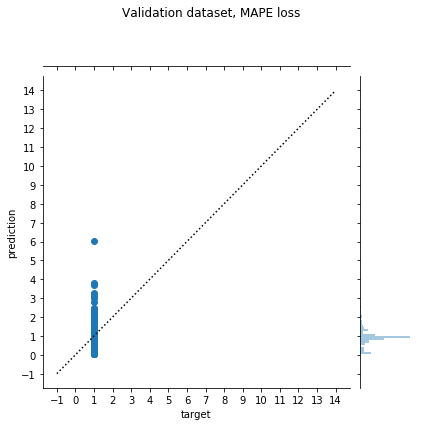

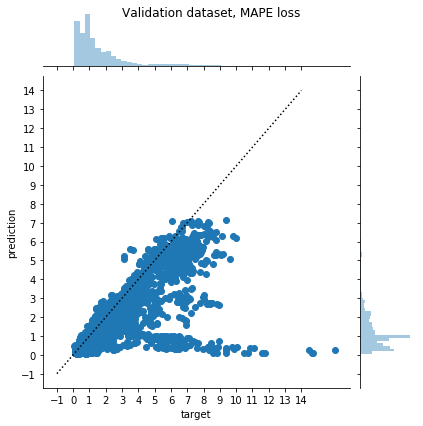

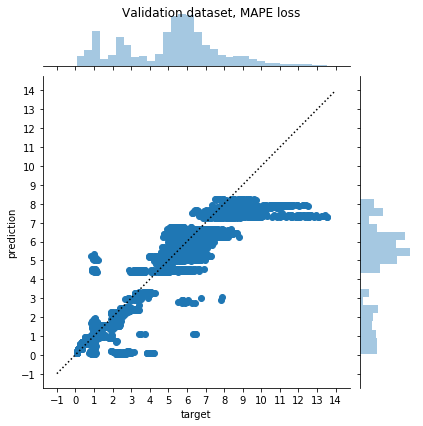

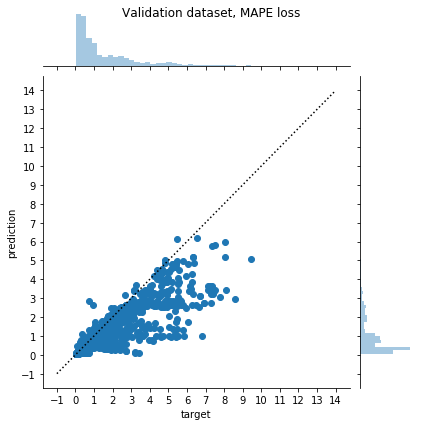

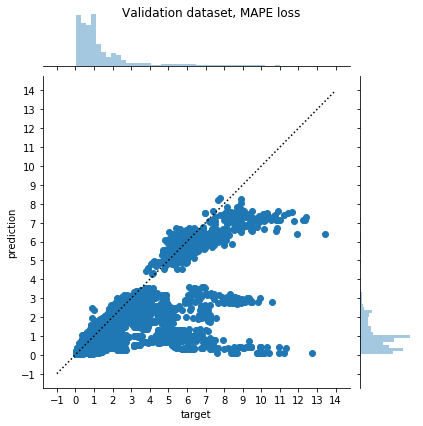

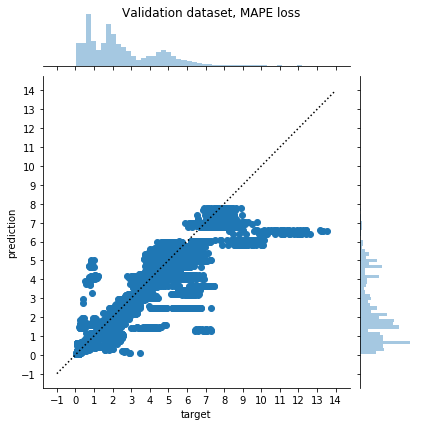

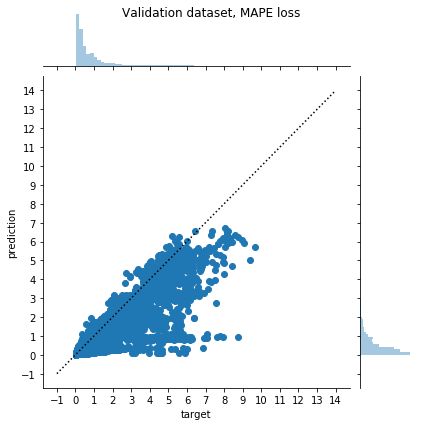

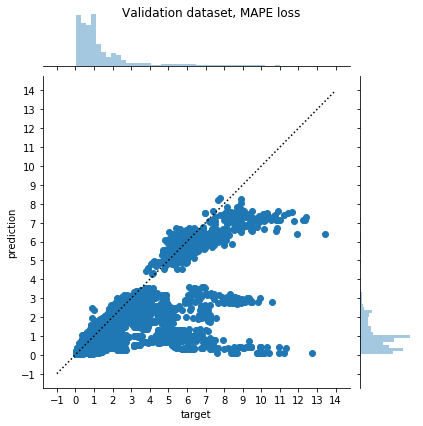

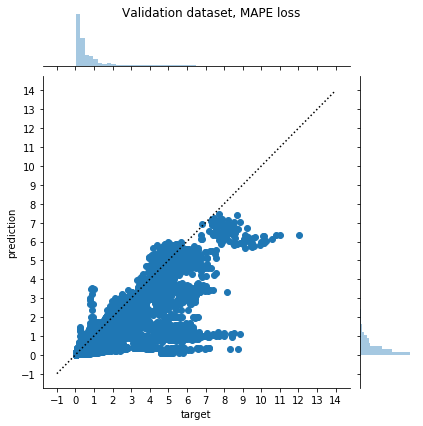

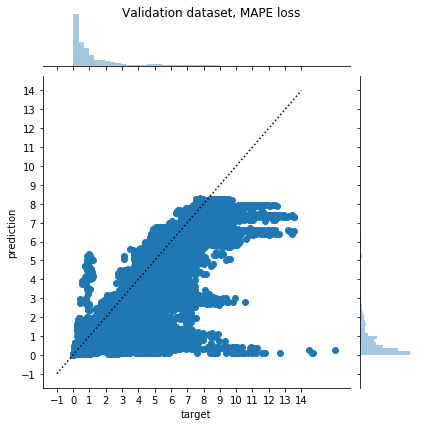

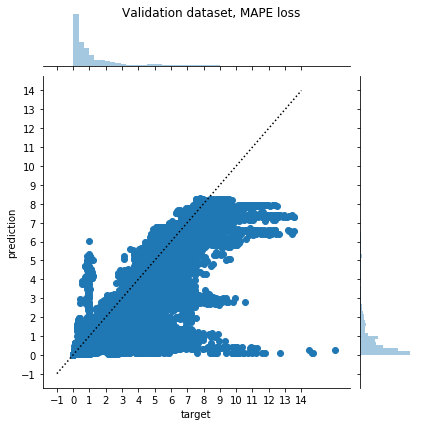

In [76]:
df1 = df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==1) & (df.unroll == 0) & (df.tile == 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==1) & (df.unroll == 1) & (df.tile == 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==1) & (df.unroll == 0) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==1) & (df.unroll == 1) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange + df.tile + df.unroll != 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df2 = df
joint_plot(df2, f"Validation dataset, {loss_func} loss")